# Feature Selection & Feature Importances

In [50]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

![baby penguin gif from Giphy](https://media.giphy.com/media/RiJuDMqd6vDgfPrZN2/giphy.gif)

Let's hang out with some penguins, loading up a dataset straight from seaborn:

In [2]:
data = sns.load_dataset('penguins')

In [3]:
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Let's clean up this dataset - two rows have quite a few null values, and 11 total do not have a value for `sex`, so let's drop rows where any data is null:

In [9]:
11/344 # only dropping 3% of data

0.03197674418604651

In [5]:
# Drop nulls here
data = data.dropna(how='any')

In [6]:
# Sanity check
data.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


### Encoding Our Data

In [13]:
data[['species','island','sex']].describe()
#only a few categories so OHE all 3

,species,island,sex
count,333,333,333
unique,3,3,2
top,Adelie,Biscoe,MALE
freq,146,163,168


In order to use the `gender`, `species` or `island` data we need to render those strings as numbers - since there are only 2-3 unique values per column, let's simply one-hot-encode those columns (aka turn the columns into a series of binary indicators).

Using Pandas' `get_dummies` : https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.get_dummies.html

In [16]:
# One hot encode our three 'object' columns
data_num = pd.get_dummies(data, columns=['species', 'island', 'sex'],
                          drop_first=True)
# might not want to drop first and explore feature importance

In [15]:
data_num.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_MALE
0,39.1,18.7,181.0,3750.0,0,0,0,1,1
1,39.5,17.4,186.0,3800.0,0,0,0,1,0
2,40.3,18.0,195.0,3250.0,0,0,0,1,0
4,36.7,19.3,193.0,3450.0,0,0,0,1,0
5,39.3,20.6,190.0,3650.0,0,0,0,1,1


You'll note that Pandas' `get_dummies` drops the first option, which means one of the species and one of the islands won't be obvious in our features. A thing to keep in mind!

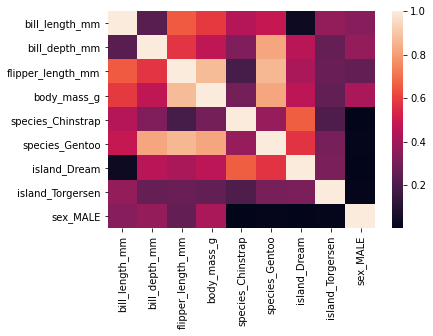

In [17]:
sns.heatmap(data_num.corr().abs())
plt.show()

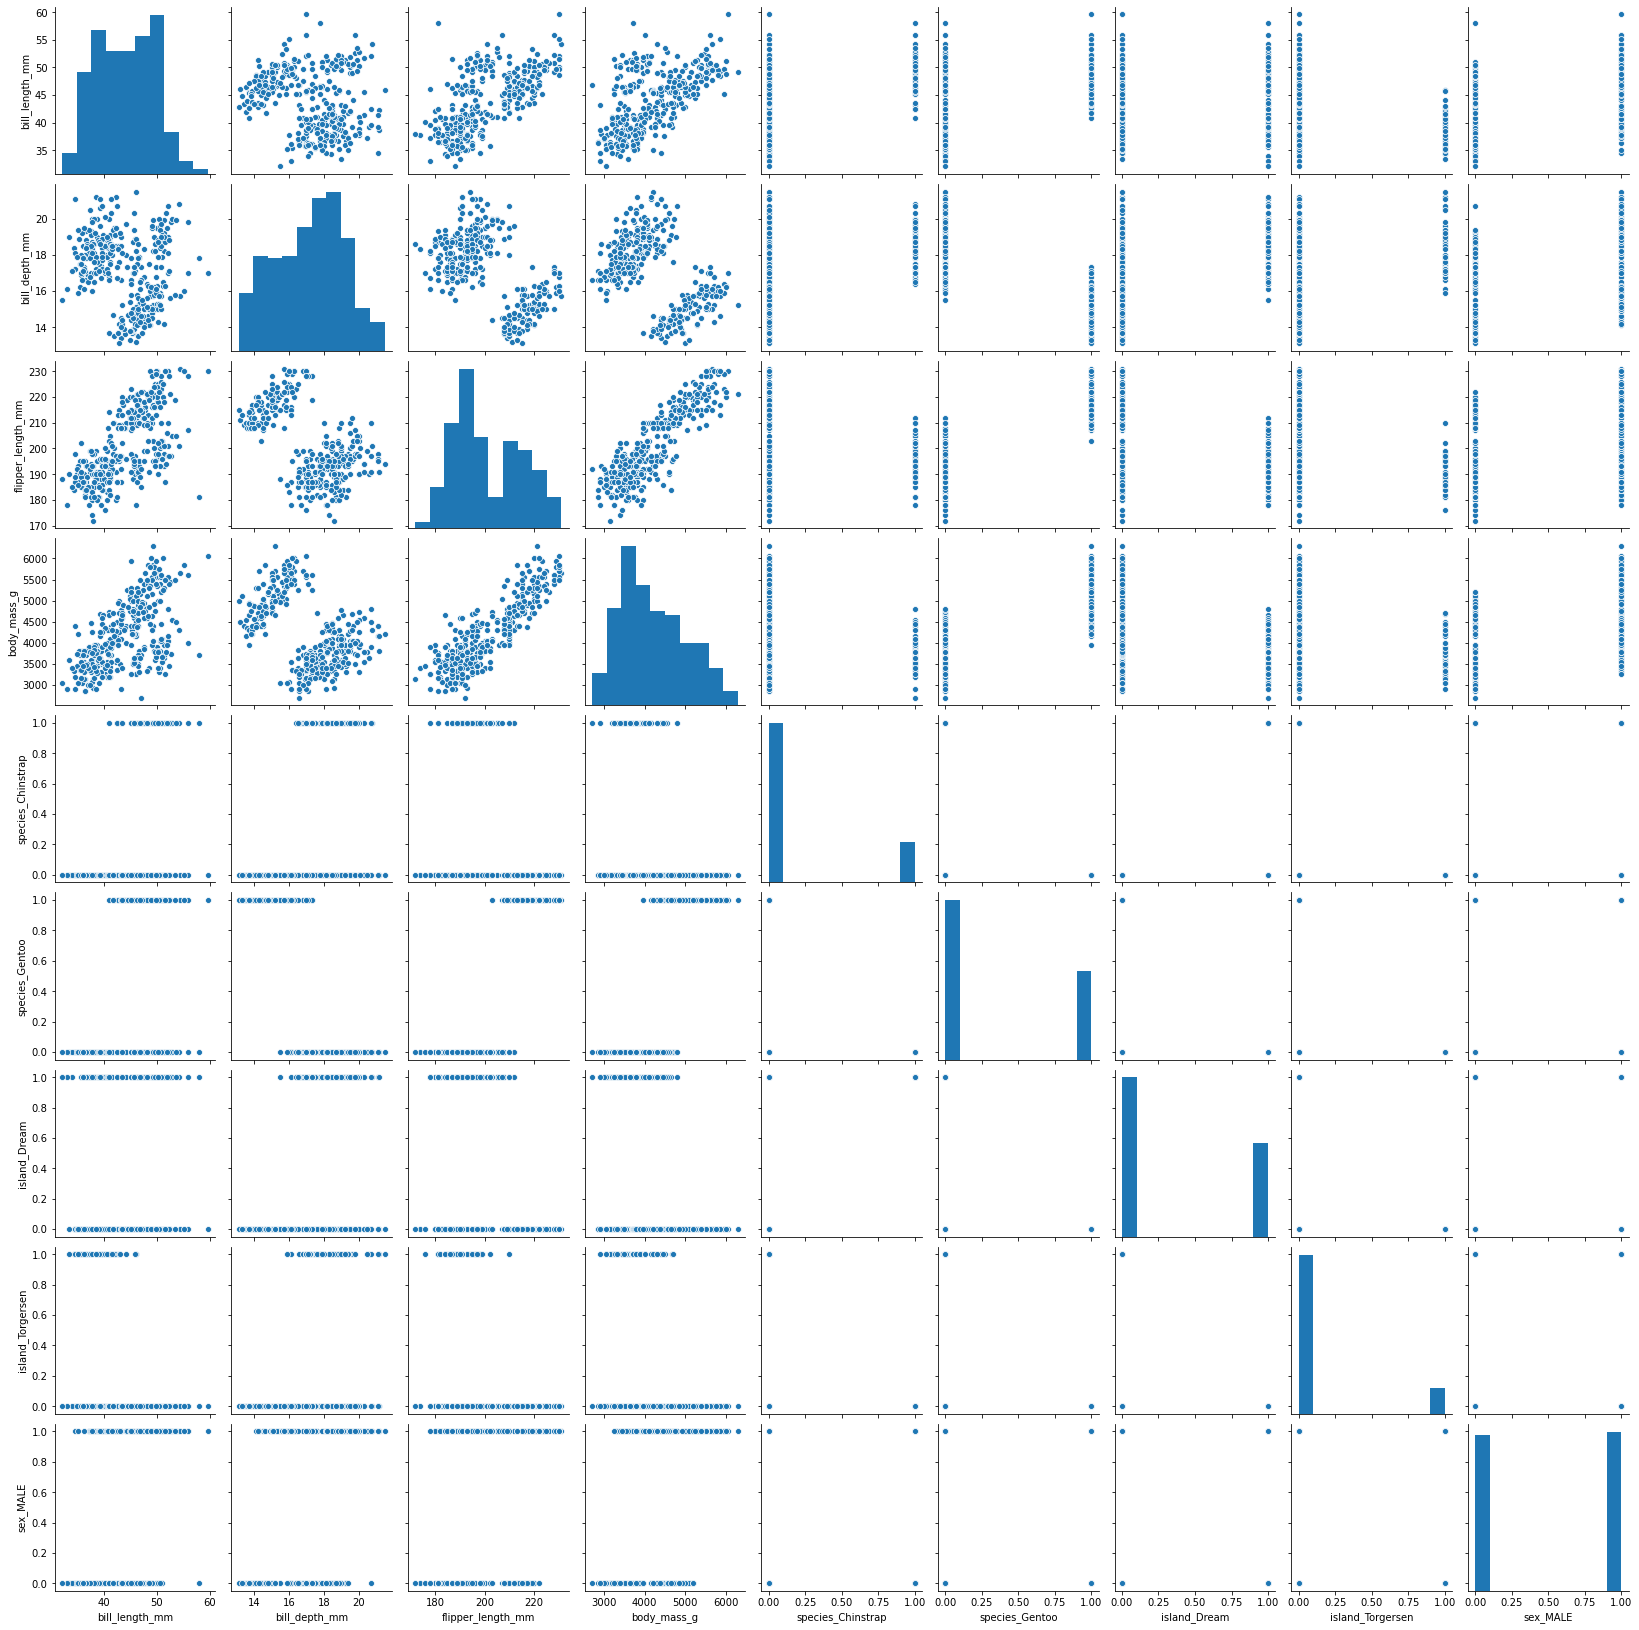

In [18]:
sns.pairplot(data_num)

The goal of this is to predict body mass, `body_mass_g`, so let's define our X and y and perform a train/test split:

In [19]:
# Define X and y
X_cols = [c for c in data_num.columns.to_list() if c not in ['body_mass_g']]

X = data_num[X_cols]
y = data_num.body_mass_g

In [20]:
# Perform a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
len(X_test) + len(X_train) == len(X)

True

In [22]:
X_train.shape

(249, 8)

In [23]:
X_test.shape

(84, 8)

In [24]:
# Instantiate a scaler
scaler = StandardScaler()

In [25]:
# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline Linear Regression Model

In [26]:
# Instantiate a linear regression model
lr = LinearRegression()

In [27]:
# Fit our model on our scaled data
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [55]:
import numpy as np

In [56]:
# Evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}") #can account for X amount of variance
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}") #about X amount off in predicting weight
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Root Mean Squared Error: {np.sqrt(mean_absolute_error(y_test, y_test_pred))}")

Training Scores:
R2: 0.8829981883987179
Mean Absolute Error: 218.88485675521707
---
Testing Scores:
R2: 0.8415286699070721
Mean Absolute Error: 261.5657164315671
Root Mean Squared Error: 16.17299342829172


## Feature Importance through Coefficients

Because we've scaled our data, we can explore our coefficients to see which are having more of an impact on our model.

Note! This, or using p-values from a statsmodels model, is all I expect you to do in this project - anything else we talk about today is completely optional and going above and beyond!

In [58]:
# look at the coefficients with the names of each col
dict(zip(X.columns, lr.coef_))
# pd.DataFrame.from_dict(dict(zip(X.columns, lr.coef_)), orient='index')
# coefficients need to be scaled, p values don't
#this is same as the ELI5 output

{'bill_length_mm': 44.16299255324277,
 'bill_depth_mm': 158.56454659615028,
 'flipper_length_mm': 253.77020374283697,
 'species_Chinstrap': -52.67297162072178,
 'species_Gentoo': 500.12773506867853,
 'island_Dream': -36.114616120224206,
 'island_Torgersen': -3.4514188181177805,
 'sex_MALE': 208.57164222140858}

In [30]:
# let's also look at the intercept
lr.intercept_

4184.538152610442

### [ELI5](https://eli5.readthedocs.io/en/latest/index.html)

ELI5, short for 'explain like I'm 5', is a library specifically designed to help explore feature importances. It'll help you visualize exactly what we just did above!

In [41]:
import eli5

ModuleNotFoundError: No module named 'eli5'

In [40]:
# don't have eli5? uncomment the below code
!pip install eli5

In [35]:
eli5.show_weights(lr, feature_names=list(X.columns))

NameError: name 'eli5' is not defined

### So what?

You can use feature importances, or an exploration of statistical significance through statsmodels' provided p-values, to decide which features to keep and which ones to drop in your next iteration of your model! Especially if you OHE a lot of columns, you might use this technique to grab only useful indicators rather than keeping every feature you build in your model.

Will dropping seemingly 'low' features in terms of feature importance always help improve your scores? Nope! Will each way of understanding which feature is 'important' always have the same results? Nope! But try different techniques, see what you think and what helps your model, then iterate.

In terms of interpretation, you may want to get to a final model in terms of what features are used and how you process your data - then build a version of that final model on data that isn't scaled so you can see exactly how each unit of each feature directly impacts your target!

In [36]:
lr_ns = LinearRegression()

lr_ns.fit(X_train, y_train)

# Evaluate
y_train_pred = lr_ns.predict(X_train)
y_test_pred = lr_ns.predict(X_test)

# these scores should be exactly the same
print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")

Training Scores:
R2: 0.8829981883987179
Mean Absolute Error: 218.88485675521716
---
Testing Scores:
R2: 0.841528669907072
Mean Absolute Error: 261.5657164315672


In [37]:
# BUT the feature importances will be totally different
eli5.show_weights(lr_ns, feature_names=list(X.columns))

NameError: name 'eli5' is not defined

Rather than interpret anything about this (you can NOT interpret relative feature importances based on unscaled coefficients!!), you can use these coefficients now to discuss how each unit affects the target.

Example: each additional mm of flipper length adds 17.472g of body mass, being a Gentoo penguin adds 810.346g of body mass, etc.

-----

## Above and Beyond: Regularization Terms

Suppose I have split my data into training and testing sets. Do I want my model to fit my training data _exactly_?

Often, the answer is actually 'NO!', because doing that will lead to an overfit model.

Overfitting is generally a result of high variance. High variance can be caused by:

- having irrelevant or too many predictors
- multicollinearity
- large coefficients

The first problem is about picking up on noise rather than signal.

The second problem is about having a least-squares estimate that is highly sensitive to random error.

The third is about having highly sensitive predictors.

Regularization works by introducing a factor into our model designed to enforce the stricture that the coefficients stay small, by penalizing the ones that get too large.

That is, we'll alter our loss function so that the goal now is not merely to minimize the difference between actual values and our model's predicted values. Rather, we'll add in a term to our loss function that represents the sizes of the coefficients.

There are two popular ways of doing this:

Lasso ("L1"): Minimize $\large\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}|\beta_j|]$
<br/> <br/>

Ridge ("L2"): Minimize $\large\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}\beta^2_j]$

**$\rightarrow$ Don't let these formulas be intimidating. The first term in each of these (the sum of squares) is the same, and is just the familiar loss function that we've always used. What distinguishes the Lasso Regression from the Ridge Regression is only the extra term on the right. The Lasso uses the absolute values of the coefficients, while the Ridge uses the squares of the coefficients.**

For a given value of $\lambda$, the Ridge makes for a gentler reining in of runaway coefficients. The Lasso will more quickly reduce the contribution of individual predictors down to insignificance.

For a nice discussion of these methods in Python, see https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b.

**TL;DR:**

- L1 Regularization (LASSO) is good for feature selection

- L2 Regularization (Ridge) is good for reducing the impact of multicollinear features

(also, you can do both at the same time with a technique called [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html))

### L1 Norm: [LASSO](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

(Least Absolute Shrinkage and Selection Operator)

In [ ]:
# Instantiate a lasso regression model
lasso = Lasso(alpha=.5)

In [ ]:
# Fit your new L1 model -  on the scaled data
lasso.fit(X_train_scaled, y_train)

In [ ]:
# Evaluate
y_train_pred_l1 = lasso.predict(X_train_scaled)
y_test_pred_l1 = lasso.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred_l1)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_l1)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred_l1)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_l1)}")

Remember - what's the benefit of using LASSO?

In [ ]:
data_num.columns

In [ ]:
print("Unpenalized Linear Regression Coefficients are:{}".format(lr.coef_))
print("Unpenalized Linear Regression Intercept:{}".format(lr.intercept_))
print("---")
print("Lasso Regression Coefficients are:{}".format(lasso.coef_))
print("Lasso Linear Regression Intercept:{}".format(lasso.intercept_))

### L2 Norm: [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [ ]:
# Instantiate a lasso regression model
ridge = Ridge(alpha=.5)

In [ ]:
# Fit your new L2 model -  on the scaled data
ridge.fit(X_train_scaled, y_train)

In [ ]:
# Evaluate
y_train_pred_l2 = ridge.predict(X_train_scaled)
y_test_pred_l2 = ridge.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred_l2)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_l2)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred_l2)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_l2)}")

In [ ]:
print("Unpenalized Linear Regression Coefficients are:{}".format(lr.coef_))
print("Unpenalized Linear Regression Intercept:{}".format(lr.intercept_))
print("---")
print("Ridge Regression Coefficients are:{}".format(ridge.coef_))
print("Ridge Linear Regression Intercept:{}".format(ridge.intercept_))

All together:

In [ ]:
coef_dict = {}
for loc, col in enumerate(data_num.columns):
    coef_dict[col] = {"Unpenalized": lr.coef_[loc-1],
                      "LASSO": lasso.coef_[loc-1],
                      "Ridge": ridge.coef_[loc-1]}
pd.DataFrame.from_dict(coef_dict)

### Alpha Levels??

We started with the **hyperparameter** alpha set to `0.5` for both our LASSO and Ridge Models: now let's play around with it!

In [ ]:
alphas = [.25, .5, 1, 10, 50, 100]

In [ ]:
for a in alphas:
    lasso_testing = Lasso(alpha = a)
    lasso_testing.fit(X_train_scaled, y_train)
    y_train_pred_testing = lasso_testing.predict(X_train_scaled)
    y_test_pred_testing = lasso_testing.predict(X_test_scaled)

    print(f"Training Scores at alpha: {a}")
    print(f"R2: {r2_score(y_train, y_train_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_testing)}")
    print("---")
    print(f"Testing Scores at alpha: {a}")
    print(f"R2: {r2_score(y_test, y_test_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_testing)}")
    print("---")
    print(f"Coefficients at alpha: {a} are: {lasso_testing.coef_}")
    print(f"Intercept at alpha: {a} is:{lasso_testing.intercept_}")
    print("*" * 20)

In [ ]:
for a in alphas:
    ridge_testing = Ridge(alpha = a)
    ridge_testing.fit(X_train_scaled, y_train)
    y_train_pred_testing = ridge_testing.predict(X_train_scaled)
    y_test_pred_testing = ridge_testing.predict(X_test_scaled)

    print(f"Training Scores at alpha: {a}")
    print(f"R2: {r2_score(y_train, y_train_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_testing)}")
    print("---")
    print(f"Testing Scores at alpha: {a}")
    print(f"R2: {r2_score(y_test, y_test_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_testing)}")
    print("---")
    print(f"Coefficients at alpha: {a} are: {ridge_testing.coef_}")
    print(f"Intercept at alpha: {a} is:{ridge_testing.intercept_}")
    print("*" * 20)

### Resources

- [Stats course resource from Penn State](https://online.stat.psu.edu/stat508/lesson/5), going into detail about Regression Shrinkage Methods - aka regularization. This is pretty technical, and the code is in R, but goes into good detail about the motivation of why we do this and how this works.

- Kaggle has a course on Machine Learning interpretability, with a section on [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance) if you'd like to explore that